In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np

import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import torch.nn.functional as F

In [2]:
class CNN_Mnist(nn.Module):
    def __init__(self):
        super(CNN_Mnist, self).__init__()

        self.dw1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5),
            nn.ReLU(),
        )

        self.dw2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5),
            nn.ReLU(),            
        )

        self.dw_latent = nn.Sequential(
            nn.Flatten(1),
            nn.Linear(20 * 20 * 64, 256),
        )
        
        self.latent = nn.Linear(256, 256)
        
        self.up_latent = nn.Sequential(
            nn.Linear(128, 256),
            nn.Linear(256, 20 * 20 * 64),            
        )

        self.up1 = nn.Sequential(
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=5) 
        )

        self.up2 = nn.Sequential(            
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=5) 
        )

        self.act = nn.Sigmoid()

        self.dis = nn.Sequential(
            nn.Linear(128, 1000),
            nn.LeakyReLU(0.2, True),
            nn.Linear(1000, 1000),
            nn.LeakyReLU(0.2, True),
            nn.Linear(1000, 1000),
            nn.LeakyReLU(0.2, True),            
            nn.Linear(1000, 1000),
            nn.LeakyReLU(0.2, True),            
            nn.Linear(1000, 1000),
            nn.LeakyReLU(0.2, True),            
            nn.Linear(1000, 2),
        )

    def forward(self, x):
        enc = self.dw2(self.dw1(x))
        lat = self.latent(self.dw_latent(enc))
        mu, lv = self.unwrap(lat)
        z = self.reparam(mu, lv)
        rec_lat = self.up_latent(z)
        dec = self.up2(self.up1(rec_lat.view(-1, 64, 20, 20)))
        
        z_perm = self.permute_dims(z)
        D_z = self.dis(z)
        D_z_perm = self.dis(z_perm)        
        
        return x, mu, lv, D_z, D_z_perm

    def unwrap(self, x):
        return torch.split(x, x.shape[1]//2, dim=1)

    def reparam(self, mu, lv):
        if self.training:
            std = torch.exp(0.5 * lv)
            eps = torch.randn_like(std)
            return mu + std * eps
        else:
            return mu
            
    def permute_dims(self, z):
        assert z.dim() == 2

        # z = z.permute(1, 0)
        B, _ = z.size()
        perm_z = []
        for z_j in z.split(1, 1):
            perm = torch.randperm(B).to(z.device)
            perm_z_j = z_j[perm]
            perm_z.append(perm_z_j)

        # return torch.cat(perm_z, 1).permute(1, 0)
        return torch.cat(perm_z, 1)

In [3]:
def gaussian_kls(mu, logvar, mean=False):

    klds = -0.5*(1 + logvar - mu.pow(2) - logvar.exp())

    if mean:
        reduce = lambda x: torch.mean(x, 1)
    else:
        reduce = lambda x: torch.sum(x, 1)

    total_kld = reduce(klds).mean(0, True)
    dimension_wise_kld = klds.mean(0)
    mean_kld = reduce(klds).mean(0, True)

    return total_kld, dimension_wise_kld, mean_kld

In [4]:
def factor_loss(D_z, D_z_perm):
    return 0.5 * (
        F.cross_entropy(D_z, torch.zeros(D_z.shape[0], dtype=torch.long).to(D_z.device))
        + F.cross_entropy(D_z_perm, torch.ones(D_z.shape[0], dtype=torch.long).to(D_z.device))
    )

In [5]:
transform = transforms.Compose(
    [
        transforms.ToTensor(), 
        transforms.Normalize((0.1307,), (0.3081,))
    ]
)

trainset = MNIST(root='~/data', train=True, download=True, transform=transform)
train_dl = DataLoader(trainset, batch_size=2048, shuffle=True, num_workers=2)
testset = MNIST(root='~/data', train=False, download=True, transform=transform)
test_dl = DataLoader(testset, batch_size=2048, shuffle=False, num_workers=2)

print(len(train_dl), len(test_dl))

30 5


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu", index = 0)

model = CNN_Mnist().to(device)

optimizer = Adam(params = model.parameters(), lr = 0.0001)

loss_fn = nn.MSELoss()

In [7]:
for epoch in range(1):
    model.train()
    tr_total_loss = 0
    for train_img, _ in tqdm(train_dl):
        train_img = train_img.to(device)

        gen_img, train_mu, train_lv, train_D_z, train_D_z_perm = model(train_img)
        train_rec_loss = loss_fn(gen_img, train_img)
        train_kl_loss, _, _ = gaussian_kls(train_mu, train_lv)
        train_total_corr = factor_loss(train_D_z, train_D_z_perm)
        train_loss = train_rec_loss + train_kl_loss + train_total_corr

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        tr_total_loss += train_loss.item()

    model.eval()
    with torch.no_grad():
        va_total_loss = 0
        for valid_img, _ in tqdm(test_dl):
            valid_img = valid_img.to(device)

            gen_img, valid_mu, valid_lv, valid_D_z, valid_D_z_perm = model(valid_img)
            valid_rec_loss = loss_fn(gen_img, valid_img)
            valid_kl_loss, _, _ = gaussian_kls(valid_mu, valid_lv)
            valid_total_corr = factor_loss(train_D_z, train_D_z_perm)
            valid_loss = valid_rec_loss + valid_kl_loss + valid_total_corr

            va_total_loss += valid_loss.item()

    print(f"Epoch: {epoch} - TrainLoss: {tr_total_loss/len(train_dl)} - ValidLoss: {va_total_loss/len(test_dl)}")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.17it/s]

Epoch: 0 - TrainLoss: 1.0958764592806498 - ValidLoss: 0.7414220094680786


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.54it/s]


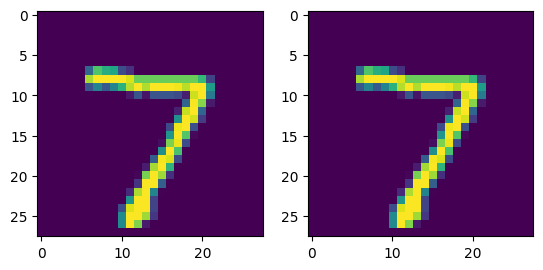

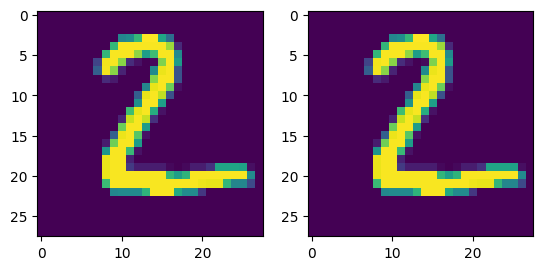

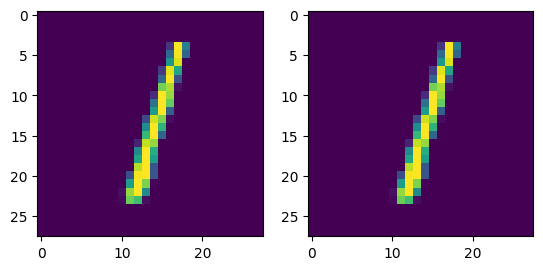

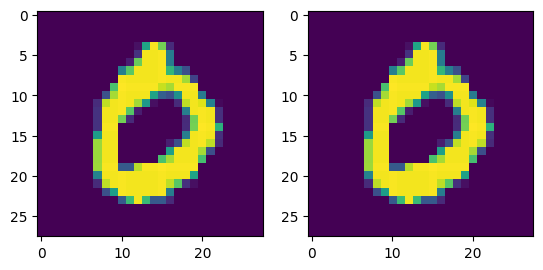

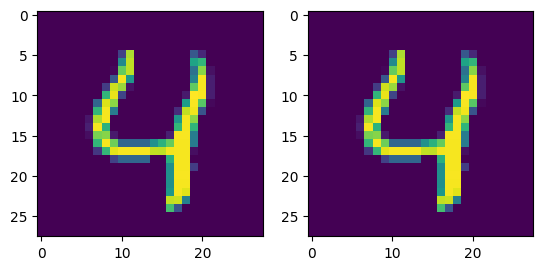

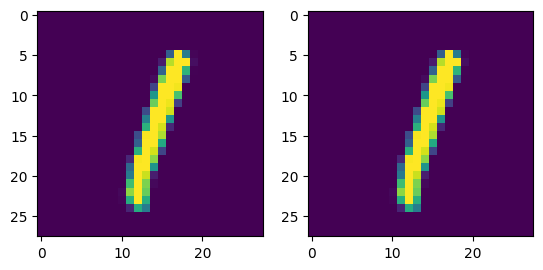

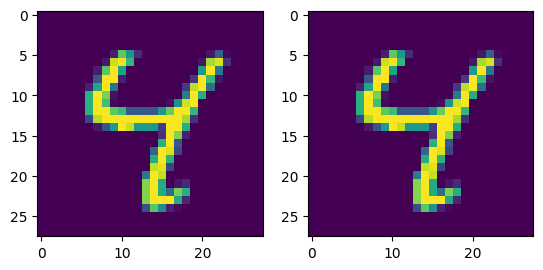

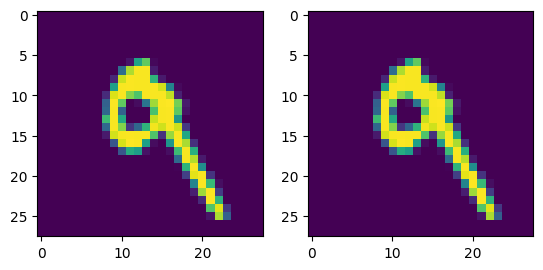

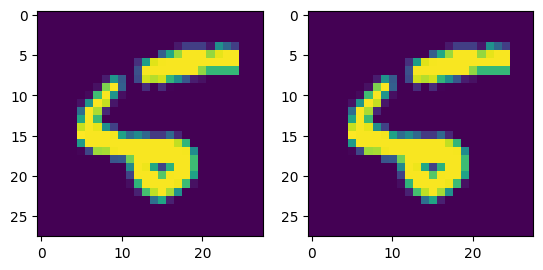

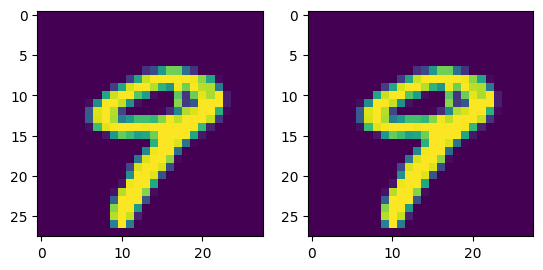

In [8]:
model.eval()
with torch.no_grad():
    for test_case_idx in tqdm(range(10)):
        valid_img, _ = testset[test_case_idx]
        valid_img = valid_img.unsqueeze(dim=0).to(device)

        gen_img, _, _, _, _ = model(valid_img)        

        f, axarr = plt.subplots(1, 2)
        axarr[0].imshow(valid_img[0].cpu().permute(1, -1, 0).numpy())
        axarr[1].imshow(gen_img[0].cpu().permute(1, -1, 0).numpy())